INFO:__main__:Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
INFO:__main__:scikit-learn: 1.7.0
INFO:__main__:Dataset carregado com 525000 linhas e 20 colunas.
INFO:__main__:Iniciando GridSearchCV...


Fitting 5 folds for each of 18 candidates, totalling 90 fits


INFO:__main__:Melhores parâmetros: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
INFO:__main__:Melhor F1 Macro (validação): 0.8592


              precision    recall  f1-score   support

    contábil       1.00      0.91      0.95     26147
  financeiro       0.93      0.70      0.80     39474
      fiscal       0.47      0.97      0.63     13156
    jurídico       1.00      1.00      1.00     13101
  tributário       1.00      0.85      0.92     13122

    accuracy                           0.84    105000
   macro avg       0.88      0.89      0.86    105000
weighted avg       0.91      0.84      0.86    105000

Acurácia: 0.8414
F1-score macro: 0.8597


<Figure size 800x600 with 0 Axes>

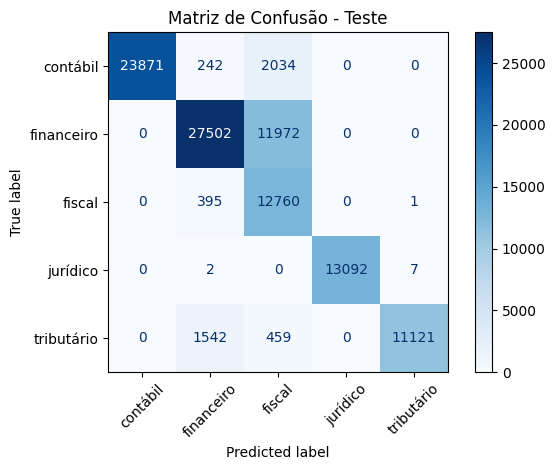

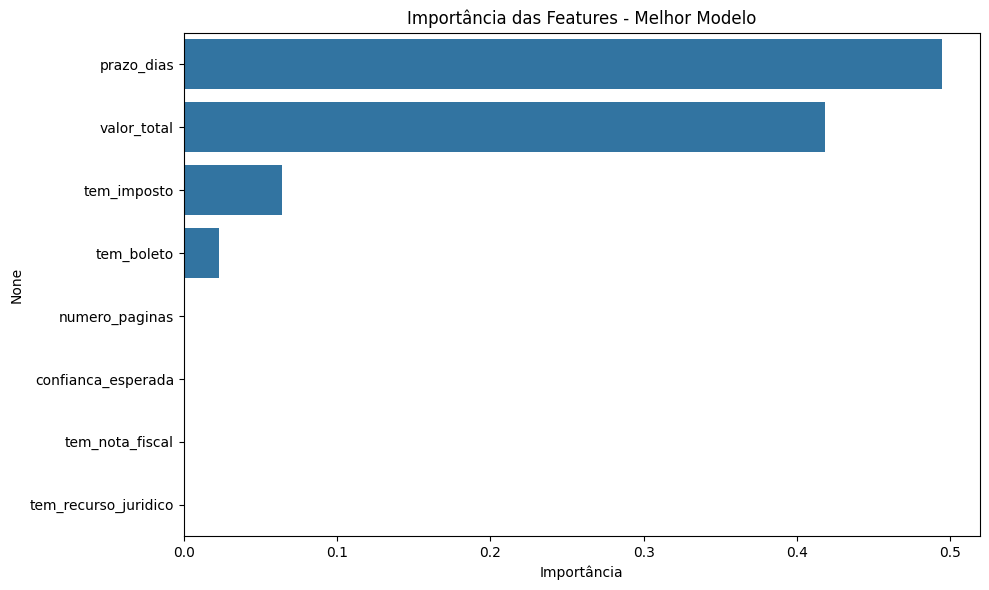

INFO:__main__:Melhor modelo salvo em ../models/rf_pipeline_best.pkl


In [ ]:
# --- Instalar dependências (execute no notebook se necessário)
!pip install pandas matplotlib seaborn scikit-learn xgboost joblib --quiet

# --- Importações principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib
import sys

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

import xgboost as xgb

# --- Configurar logging
logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

logger.info(f"Python: {sys.version}")
logger.info(f"scikit-learn: {sys.modules['sklearn'].__version__}")
logger.info(f"xgboost: {xgb.__version__}")

# --- 1. Carregar dados
DATA_PATH = "../data/processed/training_data.csv"
df = pd.read_csv(DATA_PATH)
logger.info(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

# --- 2. Converter datas e criar feature derivada prazo_dias
for col in ["data_emissao", "data_vencimento"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")
df["prazo_dias"] = (df["data_vencimento"] - df["data_emissao"]).dt.days

# --- 3. Função para extrair features simples de texto (corrigida)
def extract_text_features(df):
    df["descricao"] = df["descricao"].astype(str).fillna("")
    df["observacao"] = df["observacao"].astype(str).fillna("")
    df["tem_nota_fiscal"] = df["descricao"].str.contains("nota fiscal", case=False, na=False).astype(int)
    df["tem_imposto"] = df["descricao"].str.contains("imposto", case=False, na=False).astype(int)
    df["tem_boleto"] = df["descricao"].str.contains("boleto", case=False, na=False).astype(int)
    df["tem_recurso_juridico"] = df["observacao"].str.contains("recurso", case=False, na=False).astype(int)
    return df

df = extract_text_features(df)

# --- 4. Definir target e colunas a remover
TARGET_COL = "classificacao"
drop_cols = [
    "id", "nome_emissor", "cnpj_emissor", "cpf_responsavel", "numero_documento",
    "raiz_cnpj", "filial_cnpj", "dv_cnpj", "descricao", "observacao",
    "data_emissao", "data_vencimento",
    "categoria", "status", "tipo_documento"
]

# --- 5. Remover classes raras para stratify
y_counts = df[TARGET_COL].value_counts()
valid_classes = y_counts[y_counts >= 5].index
df = df[df[TARGET_COL].isin(valid_classes)]

# --- 6. Separar X e y
X = df.drop(columns=[col for col in drop_cols if col in df.columns] + [TARGET_COL])
y = df[TARGET_COL]

# --- 7. Converter tipos e preencher NaNs nas colunas numéricas (incluindo as criadas)
numerical_cols = [
    "valor_total", "numero_paginas", "confianca_esperada", "prazo_dias",
    "tem_nota_fiscal", "tem_imposto", "tem_boleto", "tem_recurso_juridico"
]

for col in numerical_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce")
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

# Garantir ausência de NaNs finais
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(0)
assert not X.isnull().any().any(), "Ainda há valores ausentes em X!"

# --- 8. Preprocessor e pipeline com XGBoost
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    ))
])

# --- 9. Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 10. Configurar GridSearchCV para hiperparâmetros do XGBoost
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [6, 10, 15],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__subsample": [0.8, 1],
    "classifier__colsample_bytree": [0.8, 1],
    "classifier__scale_pos_weight": [1]  # Você pode ajustar para classes desbalanceadas se quiser
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# --- 11. Treinar GridSearch
logger.info("Iniciando GridSearchCV com XGBoost...")
grid_search.fit(X_train, y_train)

logger.info(f"Melhores parâmetros: {grid_search.best_params_}")
logger.info(f"Melhor F1 Macro (validação): {grid_search.best_score_:.4f}")

# --- 12. Avaliar no conjunto teste
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-score macro: {f1_score(y_test, y_pred, average='macro'):.4f}")

# --- 13. Matriz de confusão detalhada
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()

# --- 14. Importância das features
best_xgb = grid_search.best_estimator_.named_steps["classifier"]
feature_names = numerical_cols
importances = best_xgb.feature_importances_
importances_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances_df.values, y=importances_df.index)
plt.title("Importância das Features - Melhor Modelo XGBoost")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

# --- 15. Salvar melhor modelo pipeline
MODEL_PATH = "../models/xgb_pipeline_best.pkl"
joblib.dump(grid_search.best_estimator_, MODEL_PATH)
logger.info(f"Melhor modelo salvo em {MODEL_PATH}")
